# Sieci konwolucyjne w Tensorflow dla realnych zbiorów danych

### Pobierzmy dane (zbiór realnych zdjęć kotów i psów z kaggle'a, pobierany przez stronę Microsoftu)

In [7]:
%pip install requests tensorflow

Note: you may need to restart the kernel to use updated packages.


In [8]:
import requests

url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
r = requests.get(url, allow_redirects=True)
open('dogs-vs-cats.zip', 'wb').write(r.content)

824887076

### Rozpakujmy skompresowany folder

In [9]:
!unzip -qq dogs-vs-cats.zip

### Stwórzmy trzy podzbiory danych: treningowy, testowy i walidacyjny

In [10]:
import os, shutil, pathlib
import imghdr
original_dir = pathlib.Path("PetImages")
new_base_dir = pathlib.Path("cats_vs_dogs")
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

def make_subset(subset_name, start_index, end_index):
    for category in ("Cat", "Dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{10000+i}.jpg" for i in range(start_index, end_index)]

        for fname in fnames:
          img_type = imghdr.what(original_dir/category/fname)
          if img_type in img_type_accepted_by_tf:
            shutil.copyfile(src=original_dir / category / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1300)
make_subset("test", start_index=1500, end_index=2500)

### Użyjmy klasy `image_dataset_from_directory` do wygenerowania struktur które posłużą jako zbiory ustandaryzowanych danych dla sieci

**Zadanie 3a. Patrząc na definicję zbioru treningowego, stwórz zbiór testowy i walidacyjny**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
img_shape = (img_size[0] , img_size[1] , 3)
train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()
valid_gen = ImageDataGenerator()

train_dataset = train_gen.flow_from_directory(
    directory = f"{new_base_dir}/train", 
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True ,
    batch_size = 32)
validation_dataset = valid_gen.flow_from_directory(
    directory = f"{new_base_dir}/validation", 
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True ,
    batch_size = 32)
test_dataset = test_gen.flow_from_directory(
    directory = f"{new_base_dir}/test", 
    target_size = img_size,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = True ,
    batch_size = 32)

Found 1996 images belonging to 2 classes.
Found 598 images belonging to 2 classes.
Found 1997 images belonging to 2 classes.


### Spójrzmy na rozmiar i wymiary zbiorów danych przed paczkowaniem i po paczkowaniu

In [12]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [13]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [14]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [15]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


### Zbudujmy nieduży model konwolucyjny do klasyfikacji zdjęć w Tensorflow

**W bibiliotece Tensorflow możemy dodawać kolejne warstwy sieci w postaci funkcji layer(x) gdzie x to poprzednia warstwa a layer to obecna warstwa.**

**Zadanie 3b. Dokończ architekturę modelu, dodając na końcu kolejno:**
- warstwę konwolucyjną z 2 razy większą liczbą filtrów niż wcześniejsza, takim samym rozmiar kernela i taką samą fukcją aktywacji, 
- warstwę poolingową identyczną jak wcześniejsze
- warstwę konwolucyjną identyczną jak poprzednia
- warstwę spłaszczającą (`Flatten`)
- wyjściową warstwę gęstą o jednym neuronie, która zwraca `wartość prawdpodobieństwa` - warstwę tę przypisz do zmiennej `outputs`

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(224, 224, 3))                               # warstwa wejściowa
x = layers.Rescaling(1./255)(inputs)                                    # warstwa normalizująca
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)      # warstwa konwolucyjna
x = layers.MaxPooling2D(pool_size=2)(x)                                 # warstwa poolingowa
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,097 (3.83 MB)

 Trainable params: 1,004,097 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

**Zadanie 4a. Przygotuj model do treningu, z `binarną krosentropią` jako funkcją straty, `rmsprop` jako optymalizatorem i `trafnością` jako metryką.**

In [18]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

**Zadanie 4b. Naucz model na zbiorze treningowym w 15 epokach, z walidacją na zbiorze walidacyjnym i z użyciem callbacka zapisującego najlepszy model i przypisz historię uczenia do zmiennej `history`**

In [19]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/10


/Users/maciejmaniak/Documents/cdv/deep-learning/convolutional-neural-networks/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 677ms/step - accuracy: 0.5124 - loss: 0.7358 - val_accuracy: 0.4983 - val_loss: 0.6915
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 683ms/step - accuracy: 0.5400 - loss: 0.6938 - val_accuracy: 0.5452 - val_loss: 0.6897
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 683ms/step - accuracy: 0.5492 - loss: 0.6870 - val_accuracy: 0.5334 - val_loss: 0.6819
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 673ms/step - accuracy: 0.5467 - loss: 0.6818 - val_accuracy: 0.6488 - val_loss: 0.6168
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 668ms/step - accuracy: 0.6407 - loss: 0.6352 - val_accuracy: 0.6706 - val_loss: 0.6318
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 675ms/step - accuracy: 0.6568 - loss: 0.6349 - val_accuracy: 0.7040 - val_loss: 0.5805
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 668ms/step - accuracy: 0.7028 - loss: 0.5857 - val_accuracy: 0.6906 - val_loss: 0.5814
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 666ms/step - accuracy: 0.7248 - loss: 0.5570 - val_accuracy: 0.692

### Zobaczmy performance sieci

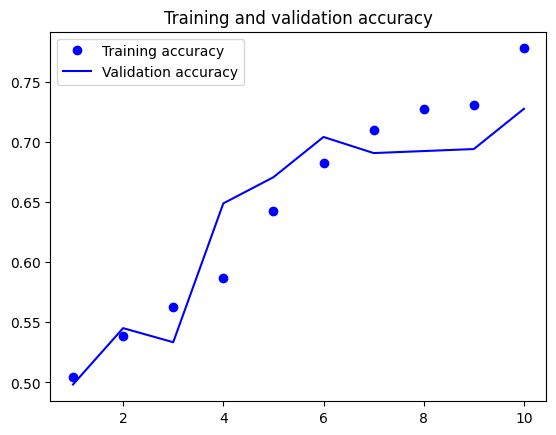

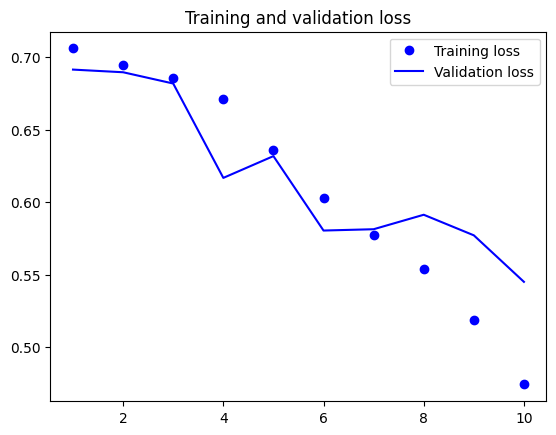

In [20]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Dokonajmy ewaluacji modelu

In [21]:
test_model = keras.models.load_model("convnet.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.7099 - loss: 0.5543
Test accuracy: 0.715


### Wykonajmy poszerzenie zbioru danych (`data augmentation`)

**Zdefiniujmy pierwszy fragment sieci, który będzie odpowiadał za modyfikację próbek**

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

### Zobaczmy zmodyfikowane w ten sposób, losowe próbki 

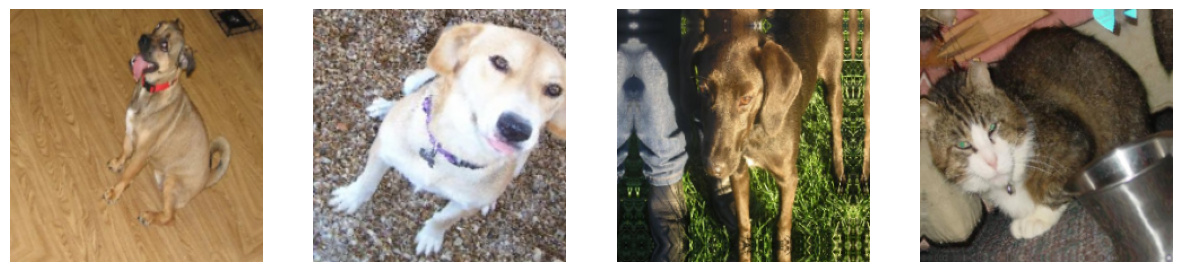

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):
  # get a batch of images and labels
  images, labels = next(train_dataset)
  # apply data augmentation only to the images
  augmented_images = data_augmentation(images)
  # changing size from (1, 224, 224, 3) to (224, 224, 3) for plotting the image
  image = np.squeeze(augmented_images[0])
  # plot raw pixel data
  ax[i].imshow(image.astype("uint8"))
  ax[i].axis('off')

### Stwórzmy nowy model, który uwzględni regularyzację poprzez rozszerzenie zbioru danych

**Zadanie 5a. Stwórz nowy model sieci konwolucyjnej, analogiczny do poprzedniego, ale ze zdefiniowanym powyżej fragmentem `'augmentacyjnym'` zaraz za wejściem oraz z warstwą `dropout`, o parametrze np. 0.5 (sprawdź w dokumentacji), między warstwą spłaszczającą a warstwą wyjściową**

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

**Zadanie 5b. Skompiluj model, naucz (historię przypisz do zmiennej `history`) i dokonaj jego ewaluacji**

In [34]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [35]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_augmentation.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_dataset, epochs=15, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 693ms/step - accuracy: 0.8068 - loss: 0.4213 - val_accuracy: 0.7040 - val_loss: 0.6482
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 671ms/step - accuracy: 0.8592 - loss: 0.3215 - val_accuracy: 0.7057 - val_loss: 0.7243
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 665ms/step - accuracy: 0.8906 - loss: 0.2702 - val_accuracy: 0.7191 - val_loss: 0.6381
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 660ms/step - accuracy: 0.9339 - loss: 0.1824 - val_accuracy: 0.7341 - val_loss: 0.7578
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 660ms/step - accuracy: 0.9394 - loss: 0.1484 - val_accuracy: 0.7124 - val_loss: 0.7830
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 663ms/step - accuracy: 0.9600 - loss: 0.1093 - val_accuracy: 0.7124 - val_loss: 0.9817
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 662ms/step - accuracy: 0.9650 - loss: 0.0928 - val_accuracy: 0.7174 - val_loss: 0.9719
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 660ms/step - accuracy: 0.9750 - loss: 0.0779 - val_accu

In [36]:
test_model = keras.models.load_model(
    "convnet_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.7282 - loss: 0.6740
Test accuracy: 0.728


### Ponownie prześledźmy proces uczenia

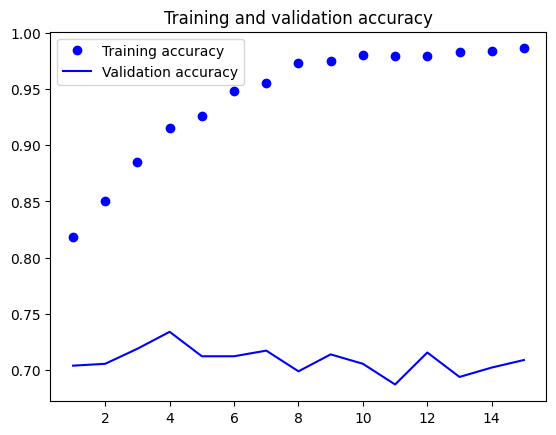

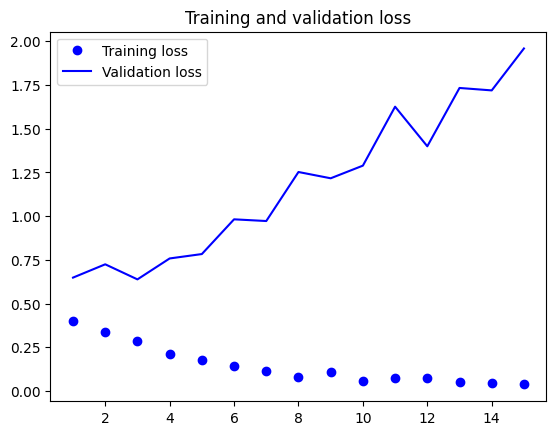

In [37]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Zadanie 5c. Jakie dostrzegasz różnice w procesie uczenia z bazowym i poszerzonym zbiorem danych?**

tu odpowiedź